In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports and Plotting Setup

In [3]:
import numpy as np
import pandas as pd
import folium
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Set up plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [4]:
#Set up for map visualization
weather = pd.read_csv('SriLanka_Weather_Dataset.csv')
cities = pd.DataFrame({'Cities' : weather.city.unique()})
latitudes = []
longitudes = []
for i in range(cities['Cities'].size):
    lat = weather.loc[weather['city'] == cities['Cities'].iloc[i]]['latitude'].iloc[0]
    long = weather.loc[weather['city'] == cities['Cities'].iloc[i]]['longitude'].iloc[0]
    latitudes.append(lat)
    longitudes.append(long)
cities['latitude'] = latitudes; cities['longitude'] = longitudes

In [ ]:
weather.shape

(147480, 24)

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147480 entries, 0 to 147479
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   time                        147480 non-null  object 
 1   weathercode                 147480 non-null  int64  
 2   temperature_2m_max          147480 non-null  float64
 3   temperature_2m_min          147480 non-null  float64
 4   temperature_2m_mean         147480 non-null  float64
 5   apparent_temperature_max    147480 non-null  float64
 6   apparent_temperature_min    147480 non-null  float64
 7   apparent_temperature_mean   147480 non-null  float64
 8   sunrise                     147480 non-null  object 
 9   sunset                      147480 non-null  object 
 10  shortwave_radiation_sum     147480 non-null  float64
 11  precipitation_sum           147480 non-null  float64
 12  rain_sum                    147480 non-null  float64
 13  snowfall_sum  

Data Preprocessing and Cleaning

In [5]:
#Remove irrelevant columns
columns_to_drop = ['sunrise', 'sunset', 'snowfall_sum', 'country']
weather.drop(columns=columns_to_drop, inplace=True)

#Check for null values and duplicates
print(weather.isnull().sum())
weather.drop_duplicates(inplace=True)

time                          0
weathercode                   0
temperature_2m_max            0
temperature_2m_min            0
temperature_2m_mean           0
apparent_temperature_max      0
apparent_temperature_min      0
apparent_temperature_mean     0
shortwave_radiation_sum       0
precipitation_sum             0
rain_sum                      0
precipitation_hours           0
windspeed_10m_max             0
windgusts_10m_max             0
winddirection_10m_dominant    0
et0_fao_evapotranspiration    0
latitude                      0
longitude                     0
elevation                     0
city                          0
dtype: int64


In [6]:
#Set date time
weather['time'] = pd.to_datetime(weather['time'])
weather['year'] = weather['time'].dt.year
weather['month'] = weather['time'].dt.month

weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147480 entries, 0 to 147479
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time                        147480 non-null  datetime64[ns]
 1   weathercode                 147480 non-null  int64         
 2   temperature_2m_max          147480 non-null  float64       
 3   temperature_2m_min          147480 non-null  float64       
 4   temperature_2m_mean         147480 non-null  float64       
 5   apparent_temperature_max    147480 non-null  float64       
 6   apparent_temperature_min    147480 non-null  float64       
 7   apparent_temperature_mean   147480 non-null  float64       
 8   shortwave_radiation_sum     147480 non-null  float64       
 9   precipitation_sum           147480 non-null  float64       
 10  rain_sum                    147480 non-null  float64       
 11  precipitation_hours         147480 non-

In [7]:
#Remove last ten dates of data for each city (used for prediction)
last_dates = weather.groupby('city')['time'].max()
for city, last_date in last_dates.items():
    dates_remove = pd.date_range(end=last_date, periods=10, freq='D')
    weather = weather[~((weather['city'] == city) & weather['time'].isin(dates_remove))]
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147180 entries, 0 to 147469
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time                        147180 non-null  datetime64[ns]
 1   weathercode                 147180 non-null  int64         
 2   temperature_2m_max          147180 non-null  float64       
 3   temperature_2m_min          147180 non-null  float64       
 4   temperature_2m_mean         147180 non-null  float64       
 5   apparent_temperature_max    147180 non-null  float64       
 6   apparent_temperature_min    147180 non-null  float64       
 7   apparent_temperature_mean   147180 non-null  float64       
 8   shortwave_radiation_sum     147180 non-null  float64       
 9   precipitation_sum           147180 non-null  float64       
 10  rain_sum                    147180 non-null  float64       
 11  precipitation_hours         147180 non-

Data Visualization

In [9]:
# Create a map
map_sri_lanka = folium.Map(width = 600, height = 400, location=[7.877083,80.697917], tiles='cartodbpositronnolabels', zoom_start=7, zoom_control=False,
               scrollWheelZoom=False,
               dragging=False)


for idx, row in cities.iterrows():
    folium.Circle(location = [row['latitude'], row['longitude']],
                  radius = 2000,
                 ).add_child(folium.Popup(row['Cities'])).add_to(map_sri_lanka)
map_sri_lanka

In [10]:
#Collect and print sample data for Trincomalee
weather_trincomalee= weather[weather['city'] == 'Trincomalee']
selected_columns = ['time', 'precipitation_hours', 'precipitation_sum', 'weathercode', 'temperature_2m_mean']
print(weather_trincomalee[selected_columns].head())

            time  precipitation_hours  precipitation_sum  weathercode  \
49160 2010-01-01                  0.0                0.0            2   
49161 2010-01-02                 11.0                2.0           51   
49162 2010-01-03                  7.0                1.4           51   
49163 2010-01-04                  0.0                0.0            2   
49164 2010-01-05                  0.0                0.0            3   

       temperature_2m_mean  
49160                 26.3  
49161                 25.7  
49162                 25.2  
49163                 24.9  
49164                 25.1  


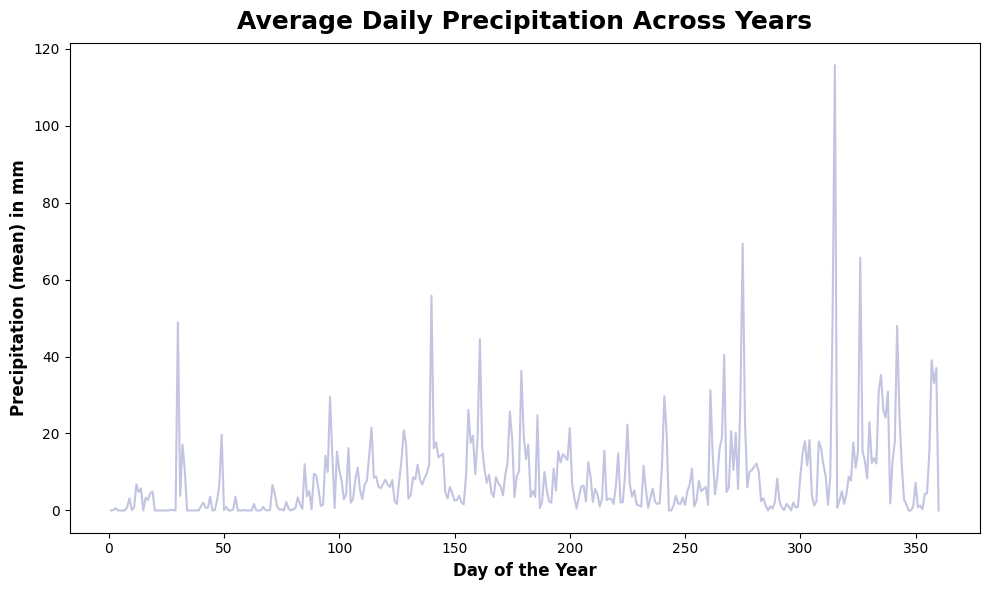

In [12]:
import matplotlib.dates as mdates

section = weather.iloc[:360].copy()

# Extract the day of the year
section['day_of_year'] = section['time'].dt.dayofyear

# Group by the day of the year and find the mean precipitation for each day
average_precipitation_by_day = section.groupby('day_of_year')['precipitation_sum'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(average_precipitation_by_day['day_of_year'], average_precipitation_by_day['precipitation_sum'], color="#C2C4E2")
ax.set_title("Average Daily Precipitation Across Years")
ax.set_ylabel("Precipitation (mean) in mm")
ax.set_xlabel("Day of the Year")

plt.show()


Correlation between factors

<Axes: >

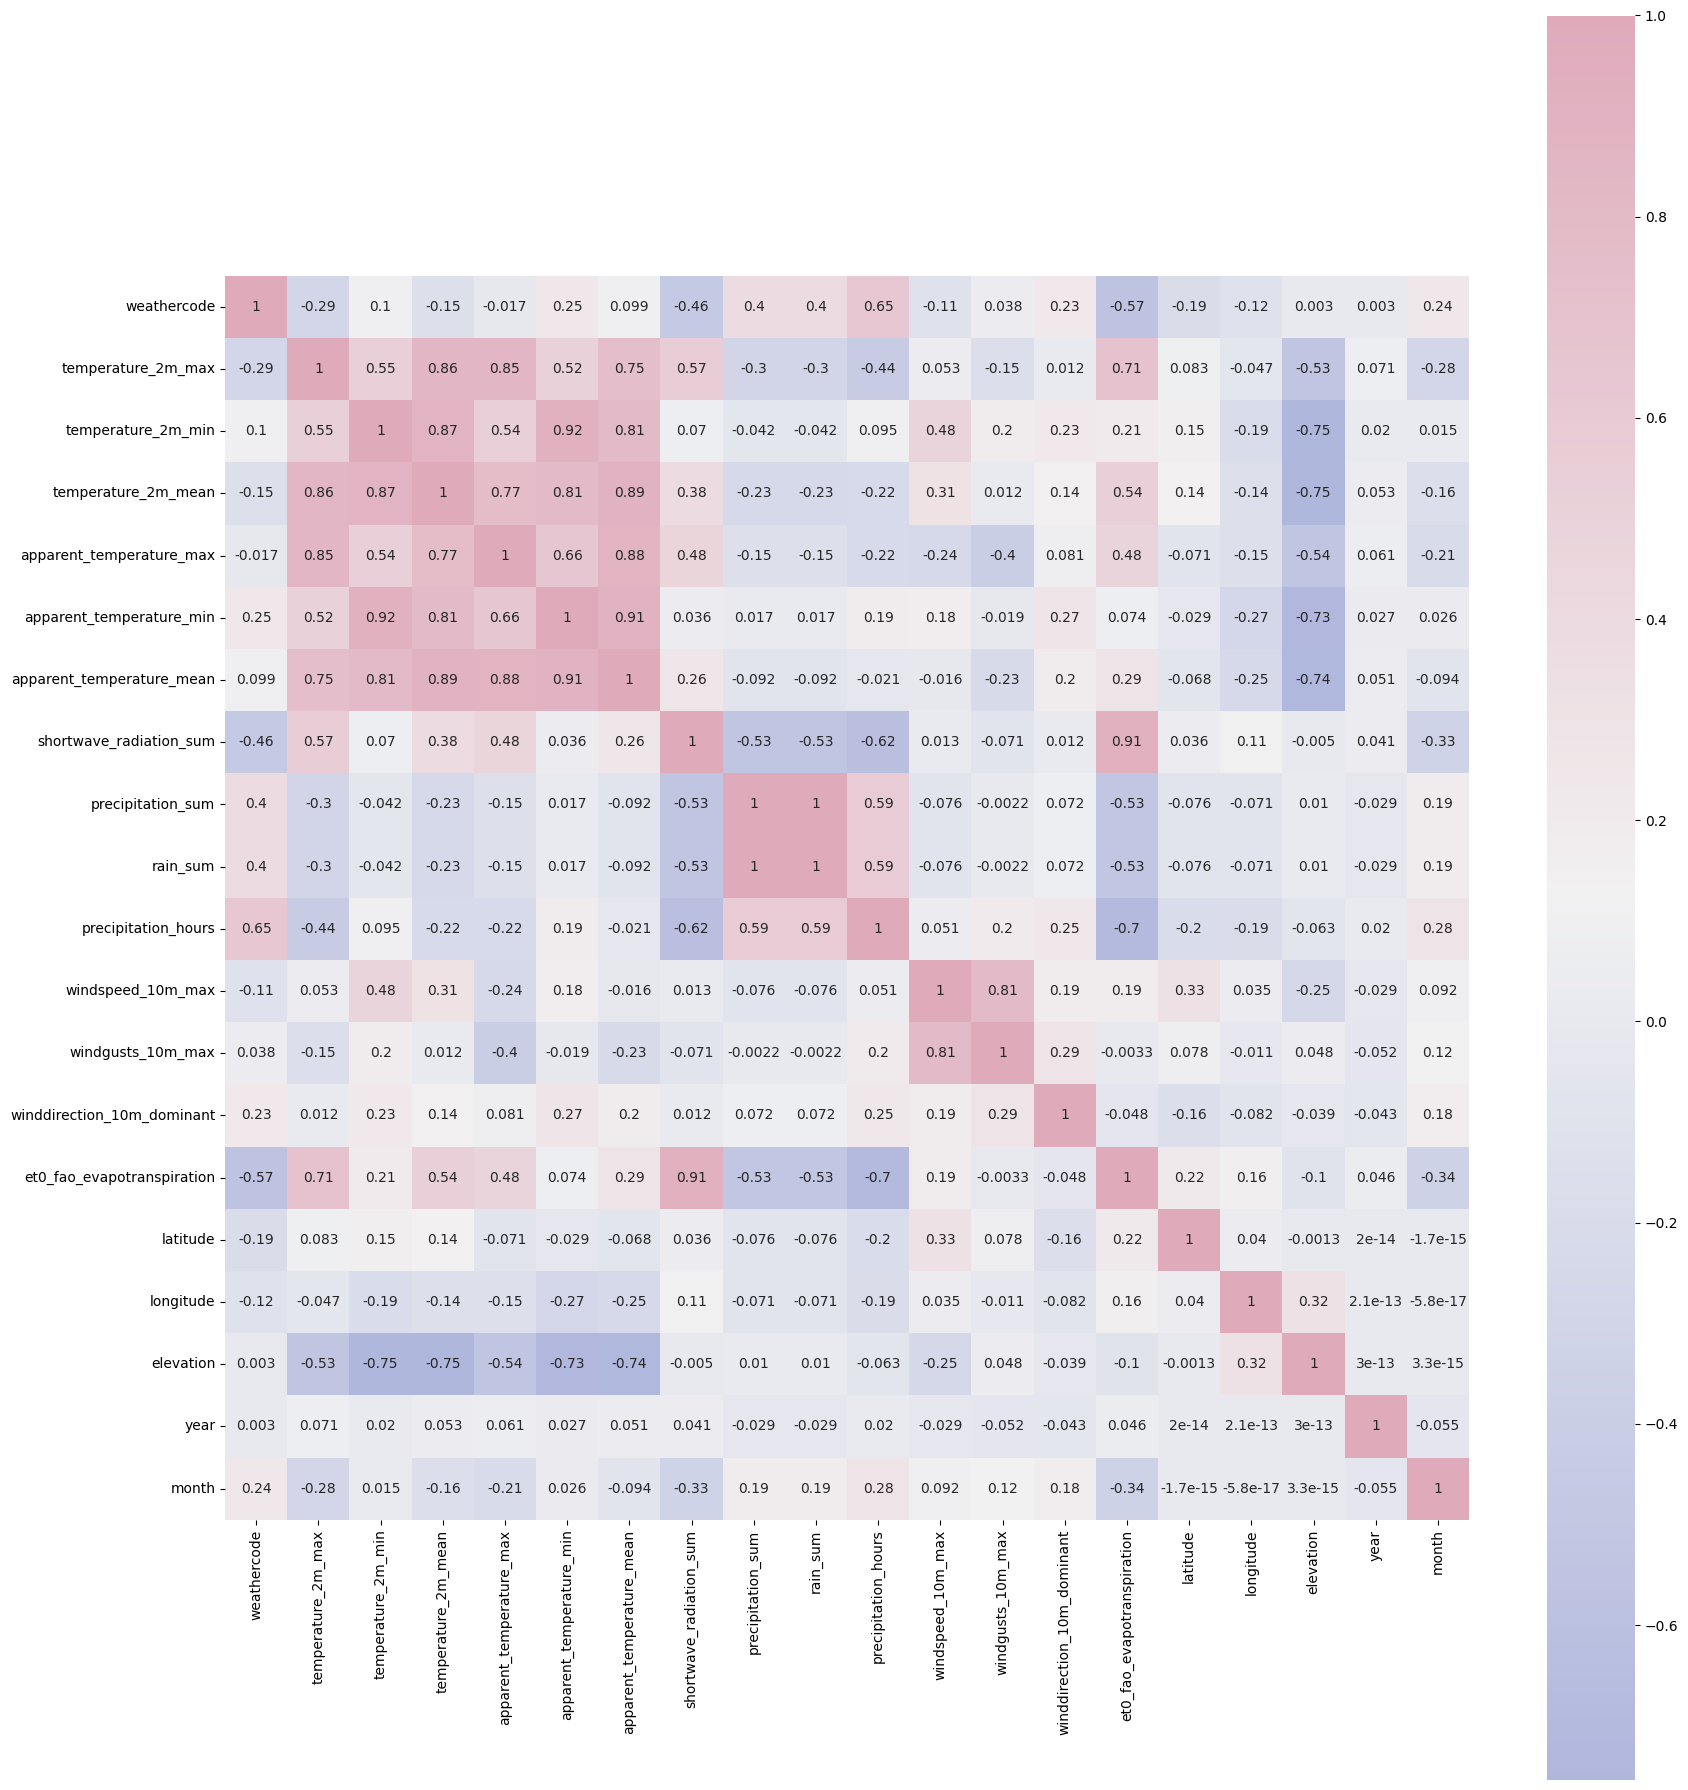

In [14]:
numeric_columns = weather.select_dtypes(include='number')
corrmat = numeric_columns.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

Exporting New Data

In [15]:
print(weather.head())
weather.to_csv('sri_lanka_precipitation_cleaned.csv', index=False)

        time  weathercode  temperature_2m_max  temperature_2m_min  \
0 2010-01-01            2                30.0                22.7   
1 2010-01-02           51                29.9                23.5   
2 2010-01-03           51                29.5                23.2   
3 2010-01-04            2                28.9                21.9   
4 2010-01-05            1                28.1                21.3   

   temperature_2m_mean  apparent_temperature_max  apparent_temperature_min  \
0                 26.1                      34.4                      25.2   
1                 26.2                      33.8                      26.2   
2                 26.0                      34.3                      26.3   
3                 25.3                      31.6                      23.4   
4                 24.5                      30.1                      23.1   

   apparent_temperature_mean  shortwave_radiation_sum  precipitation_sum  ...  \
0                       29.2       